In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from astropy.io import fits
from lsst.sims.utils import raDec2Hpid, healbin
import healpy as hp
from lsst.sims.maf.maps import TrilegalDensityMap


import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

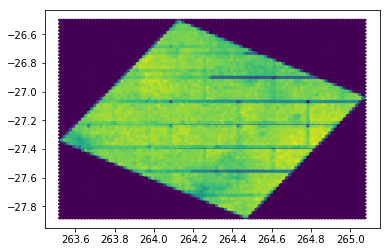

In [2]:
hdul = fits.open('decam_flux_l0.5b2.5.fits')
data = hdul[1].data.copy()
hdul.close()

nz = np.where(data['ra_ok'] != 0)[0]
plt.hexbin(data['ra_ok'][nz], data['dec_ok'][nz])


In [3]:
rmag = -2.5*np.log10(data['mean'][:,1])

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


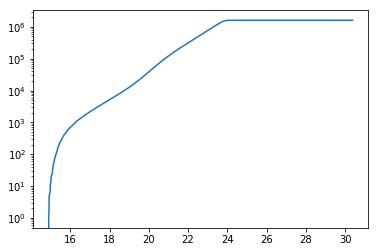

In [4]:
has_flux = np.where(data['mean'][:,1] > 0)[0]
order = np.argsort(data['mean'][:,1][has_flux])[::-1]
n_stars = np.arange(order.size)
plt.semilogy(rmag[has_flux][order], n_stars)
#plt.xlim()

In [5]:
filtername='r'
galfast = np.load('/Users/yoachim/git_repos/sims_maps/StarMaps/starDensity_%s_nside_64.npz' % filtername)
# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = galfast['starDensity'].copy()
# magnitude bins 
galfast_bins=galfast['bins'].copy()
# pixels where there were so many stars some were skipped
mask = galfast['overMaxMask']


nside = 64
tri_map = TrilegalDensityMap(filtername=filtername, nside=nside)
tri_map._readMap()

ra = 264.2
dec = -27.2

slicePoint = {'ra':[np.radians(ra)], 'dec':[np.radians(dec)]}
slicePoint = tri_map.run(slicePoint)

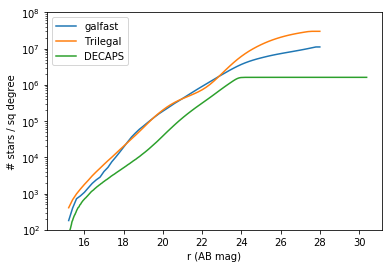

In [6]:
hpid = raDec2Hpid(nside, ra,dec)

plt.semilogy(galfast_bins[1:], starDensity[hpid], label='galfast')

plt.semilogy(slicePoint['starMapBins_r'][1:],slicePoint['starLumFunc_r'].ravel() , label='Trilegal')


plt.semilogy(rmag[has_flux][order], n_stars, label='DECAPS')


plt.ylabel('# stars / sq degree')
plt.xlabel('r (AB mag)')
plt.ylim([1e2,1e8])
plt.legend()

In [7]:
dbFile = 'baseline_v1.4_10yrs.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)


bundleList = []
sql = 'filter="r"'
metric = metrics.Coaddm5Metric()
slicer = slicers.UserPointsSlicer([ra], [dec])
plotDict = {'colorMax': 27.4}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict))

metric = metrics.MinMetric(col='seeingFwhmGeom')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))


In [8]:
bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

#bg.plotAll(closefigs=False)

Querying database SummaryAllProps with constraint filter="r" for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'seeingFwhmGeom']
Found 474955 visits
Running:  ['opsim_CoaddM5_r_USER']
Completed metric generation.
Running:  ['opsim_Min_seeingFwhmGeom_r_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [9]:
bundleList[1].metricValues

masked_array(data=[0.5868229720029249],
             mask=[False],
       fill_value=-666.0)

In [10]:

def _compCrowdError(magVector, lumFunc, seeing, singleMag=None):
    """
    Compute the photometric crowding error given the luminosity function and best seeing.

    Parameters
    ----------
    magVector : np.array
        Stellar magnitudes.
    lumFunc : np.array
        Stellar luminosity function.
    seeing : float
        The best seeing conditions. Assuming forced-photometry can use the best seeing conditions
        to help with confusion errors.
    singleMag : float (None)
        If singleMag is None, the crowding error is calculated for each mag in magVector. If
        singleMag is a float, the crowding error is interpolated to that single value.

    Returns
    -------
    np.array
        Magnitude uncertainties.

    Equation from Olsen, Blum, & Rigaut 2003, AJ, 126, 452
    """
    lumAreaArcsec = 3600.0 ** 2
    lumVector = 10 ** (-0.4 * magVector)
    coeff = np.sqrt(np.pi / lumAreaArcsec) * seeing / 2.
    myInt = (np.add.accumulate((lumVector ** 2 * lumFunc)[::-1]))[::-1]
    temp = np.sqrt(myInt) / lumVector
    if singleMag is not None:
        interp = interp1d(magVector, temp)
        temp = interp(singleMag)
    crowdError = coeff * temp
    return crowdError

In [11]:
r_vals = np.arange(16,29, 0.1)
snr_no_crowd = utils.m52snr(r_vals, bundleList[0].metricValues.data)
delta_m_no_crowd = 2.5*np.log10(1 + 1./snr_no_crowd)

In [12]:
# The limits we get to if there is no crowding
m_p1 = np.interp(0.1,delta_m_no_crowd, r_vals)
m_p2 = np.interp(0.2, delta_m_no_crowd, r_vals)

In [13]:
tri_errs = _compCrowdError(slicePoint['starMapBins_r'][1:],slicePoint['starLumFunc_r'].ravel(), bundleList[1].metricValues.data)
gf_errs = _compCrowdError(galfast_bins[1:], starDensity[hpid], bundleList[1].metricValues.data)


tri_p1 = np.interp(0.1, tri_errs, slicePoint['starMapBins_r'][1:])
tri_p2 = np.interp(0.2, tri_errs, slicePoint['starMapBins_r'][1:])

gf_p1 = np.interp(0.1, gf_errs, galfast_bins[1:])
gf_p2 = np.interp(0.2, gf_errs, galfast_bins[1:])



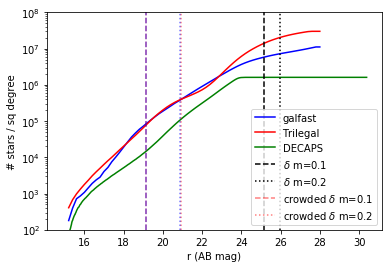

In [15]:
plt.semilogy(galfast_bins[1:], starDensity[hpid], label='galfast', color='blue')

plt.semilogy(slicePoint['starMapBins_r'][1:],slicePoint['starLumFunc_r'].ravel(), label='Trilegal',
            color='red')


plt.semilogy(rmag[has_flux][order], n_stars, label='DECAPS', color='green')

plt.axvline(m_p1, linestyle='--', color='black', label='$\delta$ m=0.1')
plt.axvline(m_p2, linestyle='dotted', color='black', label='$\delta$ m=0.2')

plt.axvline(tri_p1, linestyle='--', color='red', alpha=0.5, label='crowded $\delta$ m=0.1')
plt.axvline(tri_p2, linestyle='dotted', color='red', alpha=0.5, label='crowded $\delta$ m=0.2')


plt.axvline(gf_p1, linestyle='--', color='blue', alpha=0.5)
plt.axvline(gf_p2, linestyle='dotted', color='blue', alpha=0.5)


plt.ylabel('# stars / sq degree')
plt.xlabel('r (AB mag)')
plt.ylim([1e2,1e8])
plt.legend()
plt.savefig('stellar_densities.png')